<a href="https://colab.research.google.com/github/kmtsui/SummerProject2021/blob/pwagh/Gaussian_example_(NEW%20edit).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install some packages in order to use latex
! sudo apt-get update
! sudo apt-get install texlive-latex-recommended 
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended  
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip 
! unzip type1cm.zip -d /tmp/type1cm 
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm 
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm 
! sudo texhash 
! apt install cm-super
! pip install latex

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,420 kB]
Hit:12 http://ppa.launchpad.net

In [2]:
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.layers import Dense, Input
from keras.models import Model
from keras.callbacks import EarlyStopping

In [3]:
# Define default plot styles  

from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': False
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': False
}

plot_style_2 = {'alpha': 0.5, 'density': False}

In [4]:
# Check Versions
import tensorflow as tf
print(tf.__version__)

2.5.0


OmniFold Gaussian Toy Example
Setup the Datasets

In [5]:
mu0_x = 0
sigma0_x = 1

mu0_y = 0
sigma0_y = 1

eff = 0.1 #fraction of true but not reco
fake = 0.1 #fraction of reco but not true

back = 0.1 #fraction of a background process that we would like to subtract

In [6]:
N = 10**5

# param = (mu, sigma)
theta0_param_x = (mu0_x, sigma0_x)  # synthetic sample
theta_unknown_param_x = (0.2, 0.8)  # this is the data (the target)
background_param_x = (0, 1.2)  # background
epsilon_x = sigma0_x / 2.  # Smearing width

dummyval_x = -10 #a value for examples that don't pass one of the measured/ideal selections

#Synthetic
theta0_G_x = np.random.normal(theta0_param_x[0], theta0_param_x[1],N)  # Generator-level synthetic sample
theta0_S_x = np.array([(x + np.random.normal(0, epsilon_x)) for x in theta0_G_x])  # Detector smearing for synthetic sample
pass_reco_x = np.random.binomial(1,1.-eff,len(theta0_G_x))
pass_truth_x = np.random.binomial(1,1.-fake,len(theta0_G_x))
theta0_S_x[pass_reco_x==0] = dummyval_x
theta0_G_x[pass_truth_x==0] = dummyval_x

theta0_background_x = np.random.normal(background_param_x[0],background_param_x[1], int(N*back))
theta0_S_withback_x = np.concatenate([theta0_S_x,theta0_background_x])
theta0_G_withback_x = np.concatenate([theta0_G_x,-np.ones(int(N*back))*dummyval_x])

theta0_x = np.stack([theta0_G_x, theta0_S_x], axis=1)
labels0_x = np.zeros(len(theta0_x))

#Natural
theta_unknown_G_x = np.random.normal(theta_unknown_param_x[0],theta_unknown_param_x[1], N)
theta_unknown_S_x = np.array([(x + np.random.normal(0, epsilon_x)) for x in theta_unknown_G_x]) 
pass_reco_x = np.random.binomial(1,1.-eff,len(theta_unknown_G_x))
pass_truth_x = np.random.binomial(1,1.-fake,len(theta_unknown_G_x))
theta_unknown_S_x[pass_reco_x==0] = dummyval_x
theta_unknown_G_x[pass_truth_x==0] = dummyval_x

theta_background_x = np.random.normal(background_param_x[0],background_param_x[1], int(N*back))
theta_unknown_S_withback_x = np.concatenate([theta_unknown_S_x,theta_background_x])
theta_unknown_G_withback_x = np.concatenate([theta_unknown_G_x,-np.ones(int(N*back))*dummyval_x])

theta_unknown_x = np.stack([theta_unknown_G_x, theta_unknown_S_x], axis=1)
labels_unknown_x = np.ones(len(theta_unknown_x))



# param = (mu, sigma)
theta0_param_y = (mu0_y, sigma0_y)  # synthetic sample
theta_unknown_param_y = (0.2, 0.8)  # this is the data (the target)
background_param_y = (0, 1.2)  # background
epsilon_y = sigma0_y / 2.  # Smearing width

dummyval_y = -10 #a value for examples that don't pass one of the measured/ideal selections

#Synthetic
theta0_G_y = np.random.normal(theta0_param_y[0], theta0_param_y[1],N)  # Generator-level synthetic sample
theta0_S_y = np.array([(x + np.random.normal(0, epsilon_y)) for x in theta0_G_y])  # Detector smearing for synthetic sample
pass_reco_y = np.random.binomial(1,1.-eff,len(theta0_G_y))
pass_truth_y = np.random.binomial(1,1.-fake,len(theta0_G_y))
theta0_S_y[pass_reco_x==0] = dummyval_y
theta0_G_y[pass_truth_x==0] = dummyval_y

theta0_background_y = np.random.normal(background_param_y[0],background_param_y[1], int(N*back))
theta0_S_withback_y = np.concatenate([theta0_S_y,theta0_background_y])
theta0_G_withback_y = np.concatenate([theta0_G_y,-np.ones(int(N*back))*dummyval_y])

theta0_y = np.stack([theta0_G_y, theta0_S_y], axis=1)
labels0_y = np.zeros(len(theta0_y))

#Natural
theta_unknown_G_y = np.random.normal(theta_unknown_param_y[0],theta_unknown_param_y[1], N)
theta_unknown_S_y = np.array([(x + np.random.normal(0, epsilon_y)) for x in theta_unknown_G_y]) 
pass_reco_y = np.random.binomial(1,1.-eff,len(theta_unknown_G_y))
pass_truth_y = np.random.binomial(1,1.-fake,len(theta_unknown_G_y))
theta_unknown_S_y[pass_reco_x==0] = dummyval_y
theta_unknown_G_y[pass_truth_x==0] = dummyval_y

theta_background_y = np.random.normal(background_param_y[0],background_param_y[1], int(N*back))
theta_unknown_S_withback_y = np.concatenate([theta_unknown_S_y,theta_background_y])
theta_unknown_G_withback_y = np.concatenate([theta_unknown_G_y,-np.ones(int(N*back))*dummyval_y])

theta_unknown_y = np.stack([theta_unknown_G_y, theta_unknown_S_y], axis=1)
labels_unknown_y = np.ones(len(theta_unknown_y))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


ValueError: ignored

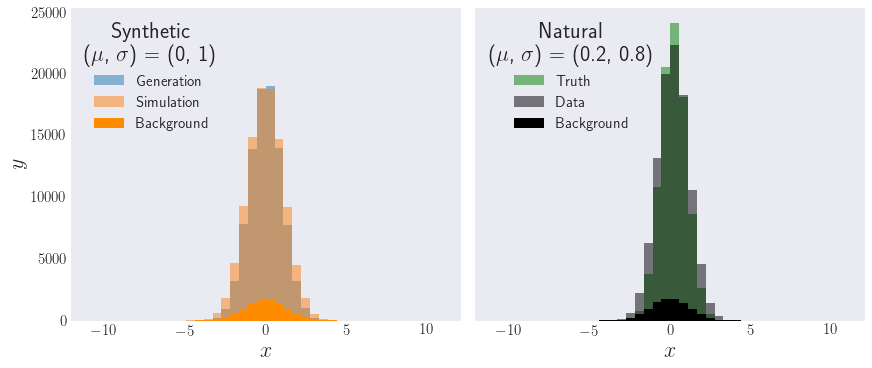

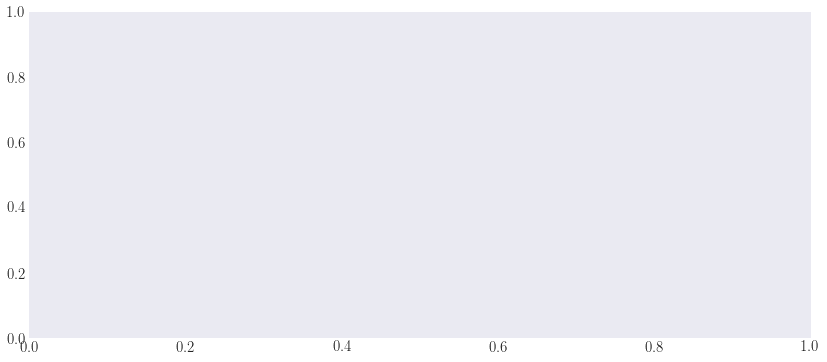

In [32]:
bins_x = np.linspace(-11, 11, 41)
bins_y = np.linspace(-11, 11, 41)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)


ax[0].set_xlabel('$x$')
ax[0].set_ylabel('Events per bin')
ax[0].hist(theta0_G_x[theta0_G_x!=dummyval_x], bins=bins_x, **plot_style_2, label='Generation')
ax[0].hist(theta0_S_withback_x[theta0_S_withback_x!=dummyval_x], bins=bins_x, **plot_style_2, label='Simulation')
ax[0].hist(theta0_S_withback_x[theta0_G_withback_x==-dummyval_x], bins=bins_x, color="darkorange", label='Background')
legend = ax[0].legend(
    title='Synthetic\n($\mu$, $\sigma$) = {}'.format(theta0_param_x),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')


ax[1].set_xlabel('$x$')
ax[1].hist(theta_unknown_G_x[theta_unknown_G_x!=dummyval_x], bins=bins_x, **plot_style_2, label='Truth',color="green")
ax[1].hist(theta_unknown_S_withback_x[theta_unknown_S_withback_x!=dummyval_x], bins=bins_x, **plot_style_2, label='Data',color="black")
ax[1].hist(theta_unknown_S_withback_x[theta_unknown_G_withback_x==-dummyval_x], bins=bins_x, label='Background',color="black")
legend = ax[1].legend(
    title='Natural\n($\mu$, $\sigma$) = {}'.format(theta_unknown_param_x),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

# 2D histogram

fig2 = plt.figure()
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$y$')
plt.hist2d(theta0_G_x[theta0_G_x!=dummyval_x], theta0_G_y[theta0_G_y!=dummyval_y], bins=bins_x) 
cbar = plt.colorbar()
cbar.ax.set_ylabel('Events per bin')

legend = ax[0].legend(
    title='Synthetic\n($\mu$, $\sigma$) = {}'.format(theta0_param_x),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')



Unfold Data

In [ ]:
iterations = 4

In [ ]:
xvals_1_x = np.concatenate((theta0_S_x, theta_unknown_S_x))
yvals_1_x = np.concatenate((labels0_x, labels_unknown_x))

xvals_2_x = np.concatenate((theta0_G_x, theta0_G_x))
yvals_2_x = np.concatenate((labels0_x, labels_unknown_x))

weights_x = np.empty(shape=(iterations, 2, len(theta0_x)))
# shape = (iteration, step, event)

inputs = Input((1, ))
hidden_layer_1_x = Dense(50, activation='relu')(inputs)
hidden_layer_2_x = Dense(50, activation='relu')(hidden_layer_1_x)
hidden_layer_3_x = Dense(50, activation='relu')(hidden_layer_2_x)
outputs_x = Dense(1, activation='sigmoid')(hidden_layer_3_x)

model_x = Model(inputs=inputs, outputs=outputs_x)

earlystopping = EarlyStopping(patience=10,
                              verbose=1,
                              restore_best_weights=True)

In [ ]:
# from NN (DCTR)
def reweight(events):
    f = model_x.predict(events, batch_size=10000)
    weights = f / (1. - f)
    return np.squeeze(np.nan_to_num(weights))

In [ ]:
#We can do the background subtraction as part of the iterative unfolding, but it is easier to do it first.

    
x_data_and_MCback_x = np.concatenate([theta0_S_withback_x[theta0_G_withback_x==-dummyval_x],
                                    theta_unknown_S_withback_x[theta_unknown_S_withback_x!=dummyval_x],
                                    theta_unknown_S_withback_x[theta_unknown_S_withback_x!=dummyval_x]])
    
y_data_and_MCback_x = np.concatenate([np.ones(len(theta0_S_withback_x[theta0_G_withback_x==-dummyval_x])),
                                    np.ones(len(theta_unknown_S_withback_x[theta_unknown_S_withback_x!=dummyval_x])),
                                    np.zeros(len(theta_unknown_S_withback_x[theta_unknown_S_withback_x!=dummyval_x]))])
    
W_data_and_MCback_x = np.concatenate([-1.*np.ones(len(theta0_S_withback_x[theta0_G_withback_x==-dummyval_x])),
                                    np.ones(len(theta_unknown_S_withback_x[theta_unknown_S_withback_x!=dummyval_x])),
                                    np.ones(len(theta_unknown_S_withback_x[theta_unknown_S_withback_x!=dummyval_x]))])

X_train_1_x, X_test_1_x, Y_train_1_x, Y_test_1_x, w_train_1_x, w_test_1_x = train_test_split(
    x_data_and_MCback_x, y_data_and_MCback_x, W_data_and_MCback_x)

    
model_x.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])
model_x.fit(X_train_1_x,
          Y_train_1_x,
          sample_weight=w_train_1_x,
          epochs=200,
          batch_size=10000,
          validation_data=(X_test_1_x, Y_test_1_x, w_test_1_x),
          callbacks=[earlystopping],
          verbose=1)

Epoch 1/200
16/16 [==============================] - 7s 395ms/step - loss: 0.6285 - accuracy: 0.4837 - val_loss: 0.6257 - val_accuracy: 0.4738
Epoch 2/200
16/16 [==============================] - 0s 23ms/step - loss: 0.6260 - accuracy: 0.4756 - val_loss: 0.6256 - val_accuracy: 0.4738
Epoch 3/200
16/16 [==============================] - 0s 22ms/step - loss: 0.6262 - accuracy: 0.4752 - val_loss: 0.6257 - val_accuracy: 0.4738
Epoch 4/200
16/16 [==============================] - 0s 22ms/step - loss: 0.6264 - accuracy: 0.4767 - val_loss: 0.6256 - val_accuracy: 0.4738
Epoch 5/200
16/16 [==============================] - 0s 23ms/step - loss: 0.6264 - accuracy: 0.4786 - val_loss: 0.6256 - val_accuracy: 0.4738
Epoch 6/200
16/16 [==============================] - 0s 22ms/step - loss: 0.6255 - accuracy: 0.4767 - val_loss: 0.6256 - val_accuracy: 0.4738
Epoch 7/200
16/16 [==============================] - 0s 22ms/step - loss: 0.6247 - accuracy: 0.4769 - val_loss: 0.6256 - val_accuracy: 0.4738
Epoch

In [ ]:
w_data_x = reweight(theta_unknown_S_withback_x[theta_unknown_S_withback_x!=dummyval_x])

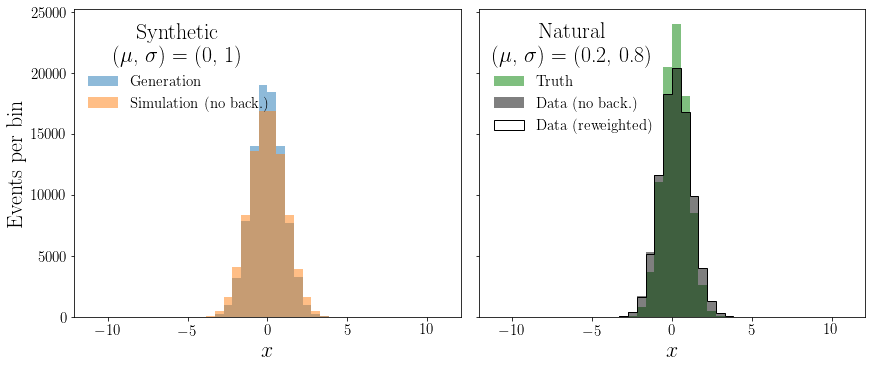

In [ ]:
bins_x = np.linspace(-11, 11, 41)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x$')
ax[0].set_ylabel('Events per bin')
ax[0].hist(theta0_G_x[theta0_G_x!=dummyval_x], bins=bins_x, **plot_style_2, label='Generation')
ax[0].hist(theta0_S_x[theta0_S_x!=dummyval_x], bins=bins_x, **plot_style_2, label='Simulation (no back.)')
legend = ax[0].legend(
    title='Synthetic\n($\mu$, $\sigma$) = {}'.format(theta0_param_x),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x$')
ax[1].hist(theta_unknown_G_x[theta_unknown_G_x!=dummyval_x], bins=bins_x, **plot_style_2, label='Truth',color="green")
ax[1].hist(theta_unknown_S_x[theta_unknown_S_x!=dummyval_x], bins=bins_x, **plot_style_2, label='Data (no back.)',color="black")
ax[1].hist(theta_unknown_S_withback_x[theta_unknown_S_withback_x!=dummyval_x], bins=bins_x, histtype="step", label='Data (reweighted)',color="black",weights=w_data_x)
legend = ax[1].legend(
    title='Natural\n($\mu$, $\sigma$) = {}'.format(theta_unknown_param_x),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

In [ ]:
# initial iterative weights are ones
weights_pull_x = np.ones(len(theta0_S_x))
weights_push_x = np.ones(len(theta0_S_x))

In [ ]:
xvals_1_x = np.concatenate((theta0_S_x, theta_unknown_S_withback_x[theta_unknown_S_withback_x!=dummyval_x]))
yvals_1_x = np.concatenate((labels0_x, np.ones(len(theta_unknown_S_withback_x[theta_unknown_S_withback_x!=dummyval_x]))))

In [ ]:
for i in range(iterations):
    print("\nITERATION: {}\n".format(i + 1))

    # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
    # weights reweighted Sim. --> Data
    print("STEP 1\n")

    weights_1_x = np.concatenate((weights_push_x, w_data_x))
    # actual weights for Sim., ones for Data (not MC weights)

    X_train_1_x, X_test_1_x, Y_train_1_x, Y_test_1_x, w_train_1_x, w_test_1_x = train_test_split(
        xvals_1_x, yvals_1_x, weights_1_x)

    model_x.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model_x.fit(X_train_1_x[X_train_1_x!=dummyval_x],
              Y_train_1_x[X_train_1_x!=dummyval_x],
              sample_weight=w_train_1_x[X_train_1_x!=dummyval_x],
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_1_x[X_test_1_x!=dummyval_x], Y_test_1_x[X_test_1_x!=dummyval_x], w_test_1_x[X_test_1_x!=dummyval_x]),
              callbacks=[earlystopping],
              verbose=1)

    weights_pull_x = weights_push_x * reweight(theta0_S_x)
    
    ###
    #Need to do something with events that don't pass reco.
    
    #One option is to take the prior:
    #weights_pull[theta0_S==dummyval] = 1. 
    
    #Another option is to assign the average weight: <w|x_true>.  To do this, we need to estimate this quantity.
    xvals_1b_x = np.concatenate([theta0_G_x[theta0_S_x!=dummyval_x],theta0_G_x[theta0_S_x!=dummyval_x]])
    yvals_1b_x = np.concatenate([np.ones(len(theta0_G_x[theta0_S_x!=dummyval_x])),np.zeros(len(theta0_G_x[theta0_S_x!=dummyval_x]))])
    weights_1b_x = np.concatenate([weights_pull_x[theta0_S_x!=dummyval_x],np.ones(len(theta0_G_x[theta0_S_x!=dummyval_x]))])
    
    X_train_1b_x, X_test_1b_x, Y_train_1b_x, Y_test_1b_x, w_train_1b_x, w_test_1b_x = train_test_split(
        xvals_1b_x, yvals_1b_x, weights_1b_x)    
    
    model_x.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model_x.fit(X_train_1b_x,
              Y_train_1b_x,
              sample_weight=w_train_1b_x,
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_1b_x, Y_test_1b_x, w_test_1b_x),
              callbacks=[earlystopping],
              verbose=1)
    
    average_vals_x = reweight(theta0_G_x[theta0_S_x==dummyval_x])
    weights_pull_x[theta0_S_x==dummyval_x] = average_vals_x
    ###
    
    weights_x[i, :1, :] = weights_pull_x

    # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
    # weights Gen. --> reweighted Gen.
    print("\nSTEP 2\n")

    weights_2_x = np.concatenate((np.ones(len(theta0_G_x)), weights_pull_x))
    # ones for Gen. (not MC weights), actual weights for (reweighted) Gen.

    X_train_2_x, X_test_2_x, Y_train_2_x, Y_test_2_x, w_train_2_x, w_test_2_x = train_test_split(
        xvals_2_x, yvals_2_x, weights_2_x)

    model_x.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model_x.fit(X_train_2_x,
              Y_train_2_x,
              sample_weight=w_train_2_x,
              epochs=200,
              batch_size=2000,
              validation_data=(X_test_2_x, Y_test_2_x, w_test_2_x),
              callbacks=[earlystopping],
              verbose=1)

    weights_push_x = reweight(theta0_G_x)
    ###
    #Need to do something with events that don't pass truth    
    
    #One option is to take the prior:
    #weights_push[theta0_G==dummyval] = 1. 
    
    #Another option is to assign the average weight: <w|x_reco>.  To do this, we need to estimate this quantity.
    xvals_1b_x = np.concatenate([theta0_S_x[theta0_G_x!=dummyval_x],theta0_S_x[theta0_G_x!=dummyval_x]])
    yvals_1b_x = np.concatenate([np.ones(len(theta0_S_x[theta0_G_x!=dummyval_x])),np.zeros(len(theta0_S_x[theta0_G_x!=dummyval_x]))])
    weights_1b_x = np.concatenate([weights_push_x[theta0_G_x!=dummyval_x],np.ones(len(theta0_S_x[theta0_G_x!=dummyval_x]))])
    
    X_train_1b_x, X_test_1b_x, Y_train_1b_x, Y_test_1b_x, w_train_1b_x, w_test_1b_x = train_test_split(
        xvals_1b_x, yvals_1b_x, weights_1b_x)    
    
    model_x.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model_x.fit(X_train_1b_x,
              Y_train_1b_x,
              sample_weight=w_train_1b_x,
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_1b_x, Y_test_1b_x, w_test_1b_x),
              callbacks=[earlystopping],
              verbose=1)
    
    average_vals_x = reweight(theta0_S_x[theta0_G_x==dummyval_x])
    weights_push_x[theta0_G_x==dummyval_x] = average_vals_x
    ###    
    
    weights_x[i, 1:2, :] = weights_push_x


ITERATION: 1

STEP 1

Epoch 1/200
15/15 [==============================] - 6s 379ms/step - loss: 0.6527 - accuracy: 0.4949 - val_loss: 0.6487 - val_accuracy: 0.5499
Epoch 2/200
15/15 [==============================] - 0s 22ms/step - loss: 0.6485 - accuracy: 0.5486 - val_loss: 0.6474 - val_accuracy: 0.5567
Epoch 3/200
15/15 [==============================] - 0s 22ms/step - loss: 0.6471 - accuracy: 0.5562 - val_loss: 0.6468 - val_accuracy: 0.5587
Epoch 4/200
15/15 [==============================] - 0s 25ms/step - loss: 0.6464 - accuracy: 0.5590 - val_loss: 0.6467 - val_accuracy: 0.5564
Epoch 5/200
15/15 [==============================] - 0s 21ms/step - loss: 0.6464 - accuracy: 0.5594 - val_loss: 0.6466 - val_accuracy: 0.5572
Epoch 6/200
15/15 [==============================] - 0s 23ms/step - loss: 0.6463 - accuracy: 0.5593 - val_loss: 0.6465 - val_accuracy: 0.5576
Epoch 7/200
15/15 [==============================] - 0s 22ms/step - loss: 0.6468 - accuracy: 0.5572 - val_loss: 0.6465 - val

ITERATION 1:
ITERATION 2:
ITERATION 3:
ITERATION 4:


<Figure size 864x360 with 0 Axes>

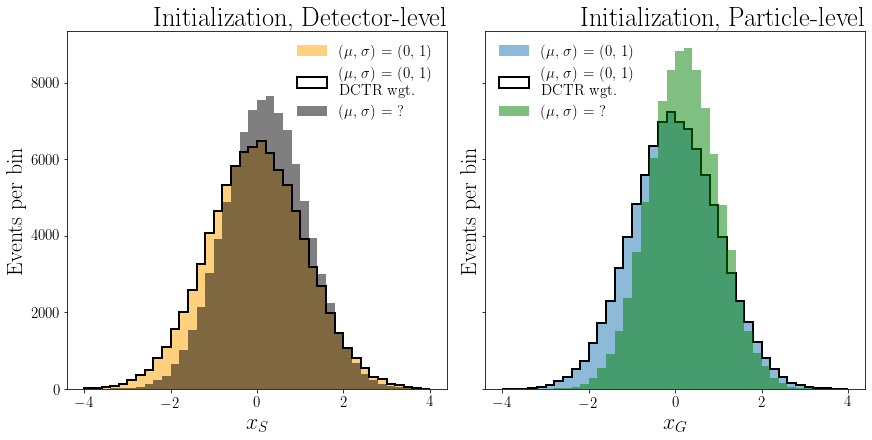

<Figure size 864x360 with 0 Axes>

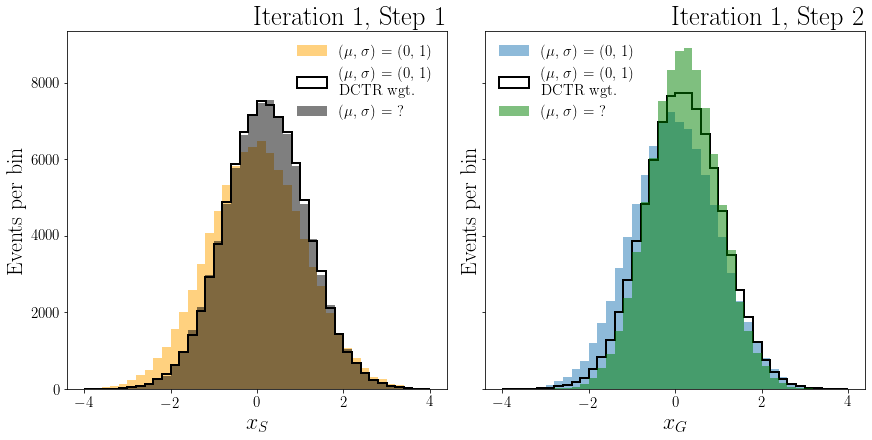

<Figure size 864x360 with 0 Axes>

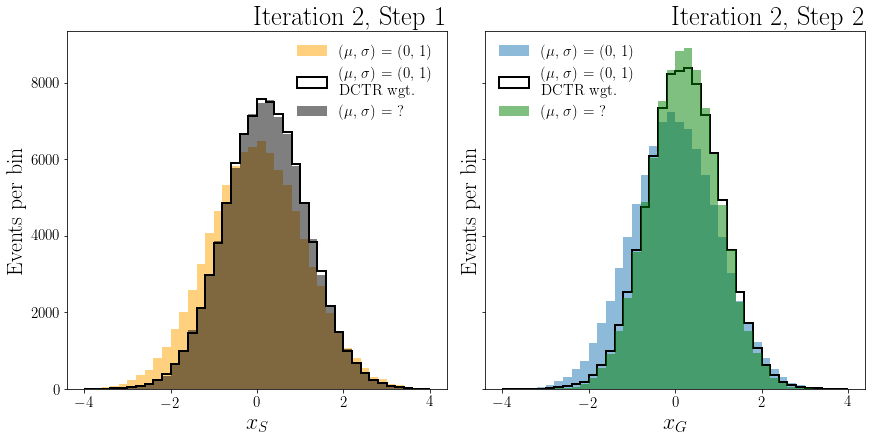

<Figure size 864x360 with 0 Axes>

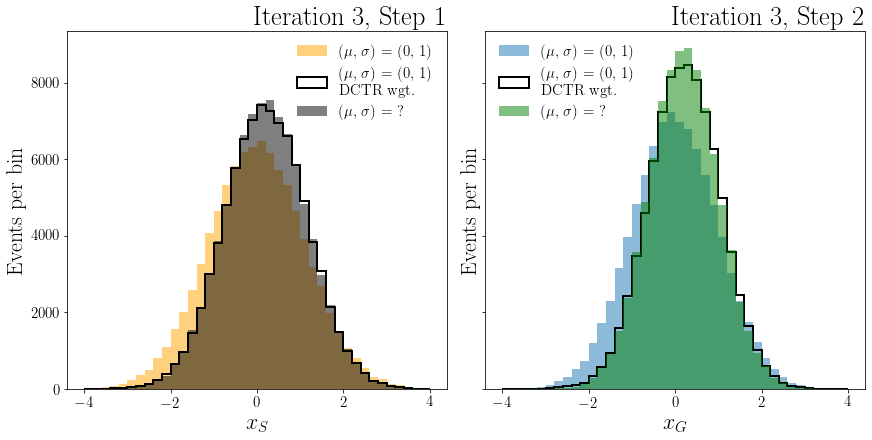

<Figure size 864x360 with 0 Axes>

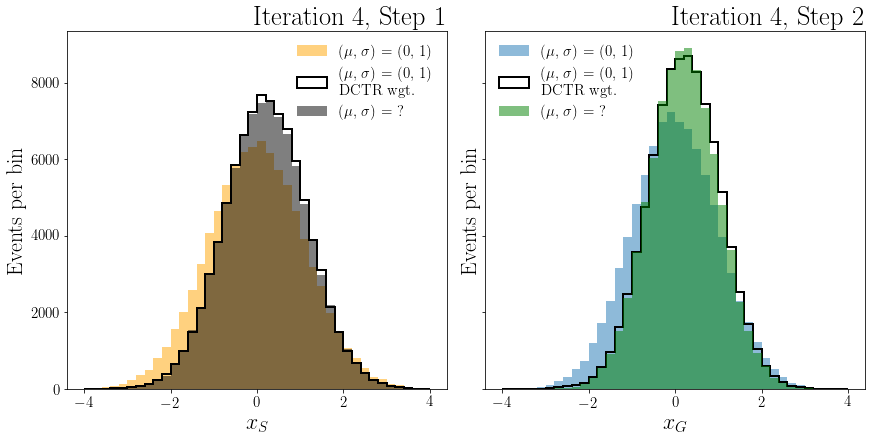

In [ ]:
bins_x = np.linspace(-4, 4, 41)

plt.figure(figsize=(12, 5))

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)

#Detector-level
ax[0].set_title("Initialization, Detector-level",style='italic',loc='right')
hist0 = ax[0].hist(theta0_S_x[theta0_S_x!=dummyval_x],
                 bins=bins_x,
                 color="orange",
                 label=r'($\mu$, $\sigma$) = {}'.format(theta0_param_x),
                 **plot_style_2)

_,_,_= ax[0].hist(
    theta0_S_x[theta0_S_x!=0],
    bins=bins_x,
    label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param_x),
    **plot_style_1)
_,_,_= ax[0].hist(theta_unknown_S_x[theta_unknown_S_x!=dummyval_x],
                 bins=bins_x,
                 label=r'($\mu$, $\sigma$) = ?',
                 weights=weights_x[i, 0, :][theta_unknown_S_x!=dummyval_x],
                 **plot_style_2,
                color="black")
ax[0].legend(frameon=False)
ax[0].set_xlabel(r"$x_S$")
ax[0].set_ylabel("Events per bin")

#Particle-level
ax[1].set_title("Initialization, Particle-level",style='italic',loc='right')
_,_,_=ax[1].hist(theta0_G_x[theta0_G_x!=dummyval_x],
                 bins=bins_x,
                 label=r'($\mu$, $\sigma$) = {}'.format(theta0_param_x),
                 **plot_style_2)

_,_,_= ax[1].hist(
    theta0_G_x[theta0_G_x!=0],
    bins=bins_x,
    label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param_x),
    **plot_style_1)
_,_,_= ax[1].hist(theta_unknown_G_x[theta_unknown_G_x!=dummyval_x],
                 bins=bins_x,
                 label=r'($\mu$, $\sigma$) = ?',
                 **plot_style_2,
                color="green")
ax[1].legend(frameon=False)
ax[1].set_xlabel(r"$x_G$")
ax[1].set_ylabel("Events per bin")


#Iterations
for i in range(iterations):
    print("ITERATION {}:".format(i + 1))
    plt.figure(figsize=(12, 5))
    
    fig, ax = plt.subplots(1,2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)
    
    #Detector-level
    ax[0].set_title("Iteration " +str(i+1)+ ", Step 1",style='italic',loc='right')
    _,_,_ = ax[0].hist(theta0_S_x[theta0_S_x!=dummyval_x],
                     bins=bins_x,
                     label=r'($\mu$, $\sigma$) = {}'.format(theta0_param_x),
                     color="orange",
                     **plot_style_2)

    _,_,_ = ax[0].hist(
        theta0_S_x[theta0_S_x!=dummyval_x],
        bins=bins_x,
        label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param_x),
        weights=weights_x[i, 0, :][theta0_S_x!=dummyval_x],
        **plot_style_1)
    _,_,_ = ax[0].hist(theta_unknown_S_x[theta_unknown_S_x!=dummyval_x],
                     bins=bins_x,
                     label=r'($\mu$, $\sigma$) = ?',
                     **plot_style_2,
                    color="black")
    ax[0].legend(frameon=False)
    ax[0].set_xlabel(r"$x_S$")
    ax[0].set_ylabel("Events per bin")
    
    #Particle-level
    ax[1].set_title("Iteration " +str(i+1)+ ", Step 2",style='italic',loc='right')
    _,_,_ = ax[1].hist(theta0_G_x[theta0_G_x!=dummyval_x],
                     bins=bins_x,
                     label=r'($\mu$, $\sigma$) = {}'.format(theta0_param_x),
                     **plot_style_2)

    _,_,_ = ax[1].hist(
        theta0_G_x[theta0_G_x!=dummyval_x],
        bins=bins_x,
        label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param_x),
        weights=weights_x[i, 1, :][theta0_G_x!=dummyval_x],
        **plot_style_1)
    _,_,_ = ax[1].hist(theta_unknown_G_x[theta_unknown_G_x!=dummyval_x],
                     bins=bins_x,
                     label=r'($\mu$, $\sigma$) = ?',
                     **plot_style_2,
                    color="green")
    ax[1].legend(frameon=False)
    ax[1].set_xlabel(r"$x_G$")
    ax[1].set_ylabel("Events per bin")

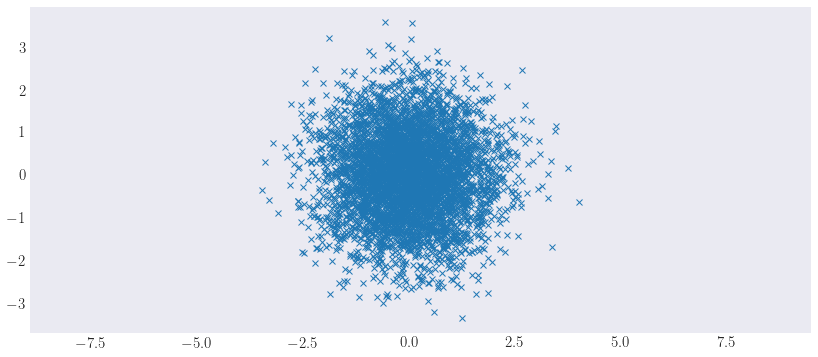

In [ ]:
import matplotlib.pyplot as plt
x, y = np.random.multivariate_normal(mean, cov, 5000).T
plt.plot(x, y, 'x')
plt.axis('equal')
plt.show()

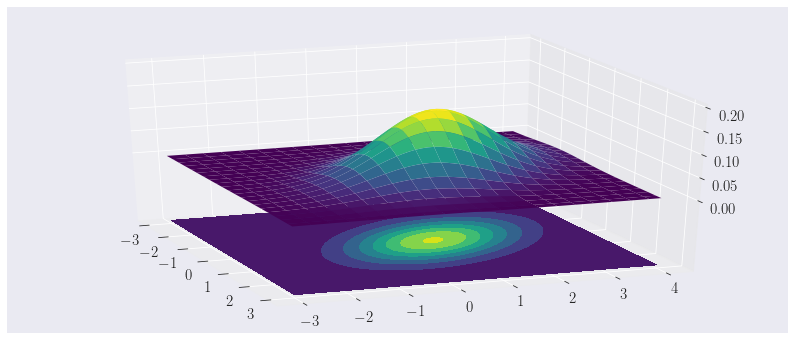

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Our 2-dimensional distribution will be over variables X and Y
N = 60
X = np.linspace(-3, 3, N)
Y = np.linspace(-3, 4, N)
X, Y = np.meshgrid(X, Y)

# Mean vector and covariance matrix
mu = np.array([0., 1.])
Sigma = np.array([[ 1. , -0.5], [-0.5,  1.5]])

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.

    """

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

# The distribution on the variables X, Y packed into pos.
Z = multivariate_gaussian(pos, mu, Sigma)

# Create a surface plot and projected filled contour plot under it.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                cmap=cm.viridis)

cset = ax.contourf(X, Y, Z, zdir='z', offset=-0.15, cmap=cm.viridis)

# Adjust the limits, ticks and view angle
ax.set_zlim(-0.15,0.2)
ax.set_zticks(np.linspace(0,0.2,5))
ax.view_init(27, -21)

plt.show()

ValueError: ignored

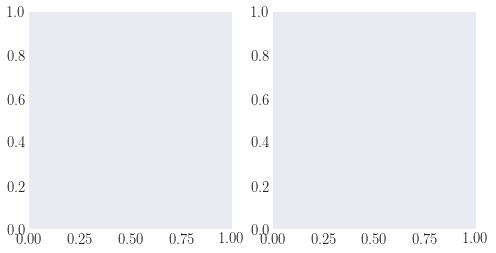

In [10]:
# Plot bivariate distribution
def generate_surface(mean, covariance, d):
    """Helper function to generate density surface."""
    nb_of_x = 50 # grid size
    x1s = np.linspace(-5, 5, num=nb_of_x)
    x2s = np.linspace(-5, 5, num=nb_of_x)
    x1, x2 = np.meshgrid(x1s, x2s) # Generate grid
    pdf = np.zeros((nb_of_x, nb_of_x))
    # Fill the cost matrix for each combination of weights
    for i in range(nb_of_x):
        for j in range(nb_of_x):
            pdf[i,j] = multivariate_normal(
                np.matrix([[x1[i,j]], [x2[i,j]]]), 
                d, mean, covariance)
    return x1, x2, pdf  # x1, x2, pdf(x1,x2)

# subplot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
d = 2  # number of dimensions

# Plot of independent Normals
bivariate_mean = np.matrix([[0.], [0.]])  # Mean
bivariate_covariance = np.matrix([
    [1., 0.], 
    [0., 1.]])  # Covariance
x1, x2, p = generate_surface(
    bivariate_mean, bivariate_covariance, d)
# Plot bivariate distribution
con = ax1.contourf(x1, x2, p, 33, cmap=cm.YlGnBu)
ax1.set_xlabel('$x_1$', fontsize=13)
ax1.set_ylabel('$x_2$', fontsize=13)
ax1.axis([-2.5, 2.5, -2.5, 2.5])
ax1.set_aspect('equal')
ax1.set_title('Independent variables', fontsize=12)

# Plot of correlated Normals
bivariate_mean = np.matrix([[0.], [1.]])  # Mean
bivariate_covariance = np.matrix([
    [1., 0.8], 
    [0.8, 1.]])  # Covariance
x1, x2, p = generate_surface(
    bivariate_mean, bivariate_covariance, d)
# Plot bivariate distribution
con = ax2.contourf(x1, x2, p, 33, cmap=cm.YlGnBu)
ax2.set_xlabel('$x_1$', fontsize=13)
ax2.set_ylabel('$x_2$', fontsize=13)
ax2.axis([-2.5, 2.5, -1.5, 3.5])
ax2.set_aspect('equal')
ax2.set_title('Correlated variables', fontsize=12)

# Add colorbar and title
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(con, cax=cbar_ax)
cbar.ax.set_ylabel('$p(x_1, x_2)$', fontsize=13)
plt.suptitle('Bivariate normal distributions', fontsize=13, y=0.95)
plt.show()
#

In [17]:
from matplotlib.image import NonUniformImage
import matplotlib.pyplot as plt

xedges = [0, 1, 3, 5]
yedges = [0, 2, 3, 4, 6]

x = np.random.normal(2, 1, 100)
y = np.random.normal(1, 1, 100)
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges))
# Histogram does not follow Cartesian convention (see Notes),
# therefore transpose H for visualization purposes.
H = H.T

fig = plt.figure(figsize=(7, 3))
ax = fig.add_subplot(131, title='imshow: square bins')
plt.imshow(H, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

ax = fig.add_subplot(132, title='pcolormesh: actual edges',
        aspect='equal')
X, Y = np.meshgrid(xedges, yedges)
ax.pcolormesh(X, Y, H)

ax = fig.add_subplot(133, title='NonUniformImage: interpolated',
        aspect='equal', xlim=xedges[[0, -1]], ylim=yedges[[0, -1]])
im = NonUniformImage(ax, interpolation='bilinear')
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
im.set_data(xcenters, ycenters, H)
ax.images.append(im)
plt.show()

TypeError: ignored

<Figure size 504x216 with 3 Axes>

In [19]:
import matplotlib as mpl
import matplotlib.pyplot as plt

xedges = [0, 1, 1.5, 3, 5]
yedges = [0, 2, 3, 4, 6]

x = np.random.normal(3, 1, 100)
y = np.random.normal(1, 1, 100)
H, xedges, yedges = np.histogram2d(y, x, bins=(xedges, yedges))

H = np.ones((4, 4)).cumsum().reshape(4, 4)
print(H[::-1])  # This shows the bin content in the order as plotted

fig = plt.figure(figsize=(7, 3))
ax = fig.add_subplot(131)
ax.set_title('imshow: equidistant')
im = plt.imshow(H, interpolation='nearest', origin='low')

ax = fig.add_subplot(132)
ax.set_title('pcolormesh: exact bin edges')
X, Y = np.meshgrid(xedges, yedges)
ax.pcolormesh(X, Y, H)
ax.set_aspect('equal')

ax = fig.add_subplot(133)
ax.set_title('NonUniformImage: interpolated')
im = mpl.image.NonUniformImage(ax, interpolation='bilinear')
xcenters = xedges[:-1] + 0.5 * (xedges[1:] - xedges[:-1])
ycenters = yedges[:-1] + 0.5 * (yedges[1:] - yedges[:-1])
im.set_data(xcenters, ycenters, H)
ax.images.append(im)
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])
ax.set_aspect('equal')
plt.show()

[[13. 14. 15. 16.]
 [ 9. 10. 11. 12.]
 [ 5.  6.  7.  8.]
 [ 1.  2.  3.  4.]]


TypeError: ignored

<Figure size 504x216 with 3 Axes>